#### 該競賽提供的train dataset其各欄位名稱及定義如下，經由這些欄位，我們可考慮是否作為feature來納入分析。
#### 例如，PassengerId（乘客編號）欄位對於預測結果應無影響可忽略不看
#### survival欄位是我們要針對Test dataset預測的是否倖存答案，因此它應該是Lable。
#### 其餘欄位則需經由分析來判斷是否跟survival有直接或間接關係，再決定是否列為特徵。

* PassengerId 乘客ID編號
* survival 是否倖存 (0 = No, 1 = Yes)
* pclass 船票等級 (1 = 1st, 2 = 2nd, 3 = 3rd)
* sex 性別
* Age 年齡
* sibsp 在船上同為兄弟姐妹或配偶的數目
* parch 在船上同為家族的父母及小孩的數目
* ticket 船票編號
* fare 船票價格
* cabin 船艙號碼
* embarked 登船的口岸 (C = Cherbourg, Q = Queenstown, S = Southampton)

#### 針對Kaggle的Titanic倖存預測競賽，將分為下列三個階段來進行，先開始第一階段。

- [x] 資料分析Data analysis
   * 資料形態、架構的掌握。
   * 資料發現Data exploration。
   * 資料的相關及變異。


In [1]:
#import pakeage
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns

In [2]:
#read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#check info
print(train.shape)
print(test.shape)
train.info()

(891, 12)
(418, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [4]:
#combine train&test
x_train = train.append(test)
print(x_train.shape)

(1309, 12)


In [5]:
#check all columns
print(x_train.columns.values)
x_train.head(5)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# have some null in train data and test data
print('Train columns with null values:\n', x_train.isnull().sum())

Train columns with null values:
 PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [7]:
#count object type 
x_train.describe(include=['O'])
# name_count have 1309, but unique 1307. It mean we have two same name

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


`1. 性別與倖存的關係` 
##### 所以我們可以先從這些object中去察看是否跟生存率有關連

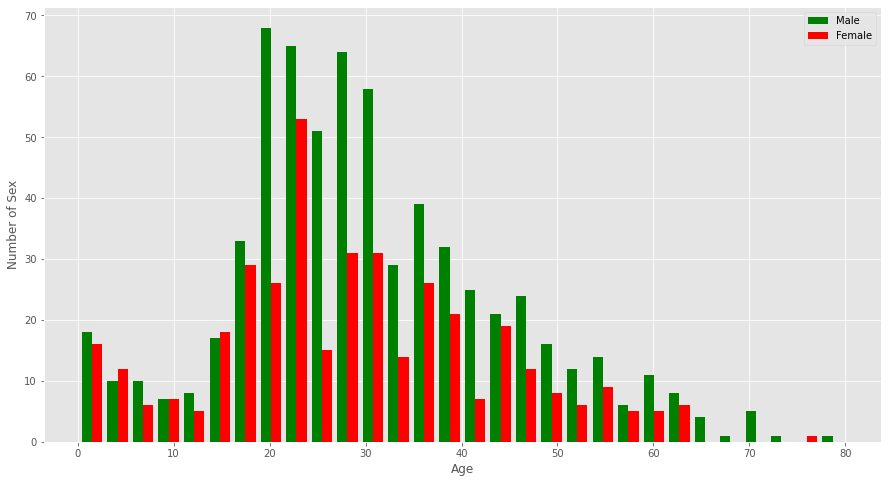

In [8]:
#first, caiculate the ratio of male and female by age group
figure = plt.figure(figsize=(15,8))
plt.hist([x_train[x_train['Sex']=='male']['Age'], 
          x_train[x_train['Sex']=='female']['Age']], 
          stacked=False, 
          color = ['g','r'], 
          bins = 30,
          label = ['Male','Female'])

plt.xlabel('Age')
plt.ylabel('Number of Sex')

plt.legend()

In [9]:
x_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
#female Survival rate more than male

,Sex,Survived
0,female,0.742038
1,male,0.188908


<AxesSubplot:>

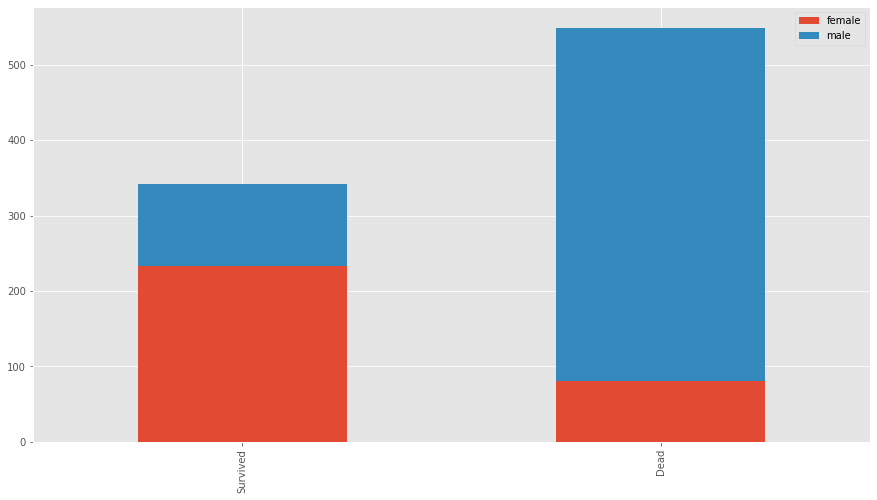

In [10]:
survived_sex = x_train[x_train['Survived']==1]['Sex'].value_counts()
dead_sex = x_train[x_train['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(15,8))
#Use 'Sex' and 'Survived' Graphy to display


`2. 名稱與倖存的關係` 
##### 我們檢視一下Name欄位，會發現該欄位除了乘客姓名之外，還帶有稱呼及職稱

In [11]:
x_train['Title1'] = x_train['Name'].str.split(", ", expand=True)[1]
x_train['Name'].str.split(", ", expand=True).head(5)

,0,1
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina
3,Futrelle,Mrs. Jacques Heath (Lily May Peel)
4,Allen,Mr. William Henry


In [12]:
x_train['Title1'].head(5)

0                               Mr. Owen Harris
1    Mrs. John Bradley (Florence Briggs Thayer)
2                                   Miss. Laina
3            Mrs. Jacques Heath (Lily May Peel)
4                             Mr. William Henry
Name: Title1, dtype: object

In [13]:
x_train['Title1'] = x_train['Title1'].str.split(". ", expand=True)[0]
# split "."

In [14]:
x_train['Title1'].head(5)
x_train['Title1'].unique()
#find all title

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'th', 'Jonkheer',
       'Dona'], dtype=object)

In [15]:
# Actually, we don't need all title (some title only few people) so we cleanup rare title names
stat_min = 10 
#while small is arbitrary, we'll use the common minimum in statistics
title_names = (x_train['Title1'].value_counts() < stat_min) 
#this will create a true false series with title name as index

x_train['Title2'] = x_train['Title1'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(x_train['Title2'].value_counts())

Mr        757
Miss      260
Mrs       197
Master     61
Misc       34
Name: Title2, dtype: int64


In [16]:
x_train.groupby(['Title2','Pclass'])['Age'].mean()

Title2  Pclass
Master  1          6.984000
        2          2.757273
        3          6.090000
Misc    1         44.285714
        2         39.545455
        3               NaN
Miss    1         30.338983
        2         20.717083
        3         17.360874
Mr      1         41.450758
        2         32.346715
        3         28.318910
Mrs     1         43.208955
        2         33.518519
        3         32.326531
Name: Age, dtype: float64

In [17]:
survived_num = x_train[x_train['Survived']==1]['Title2'].value_counts()
print('-'*5 + 'survived_num' + '-'*5  )
print(survived_num)

died_num = x_train[x_train['Survived']==0]['Title2'].value_counts()
print('-'*5 + 'died_num' + '-'*5  )
print(died_num)

survived_ratio = (100*survived_num/(survived_num+died_num))
print('-'*5 + 'survived_ratio' + '-'*5 )
print(survived_ratio)

-----survived_num-----
Miss      127
Mrs        99
Mr         81
Master     23
Misc       12
Name: Title2, dtype: int64
-----died_num-----
Mr        436
Miss       55
Mrs        26
Master     17
Misc       15
Name: Title2, dtype: int64
-----survived_ratio-----
Master    57.500000
Misc      44.444444
Miss      69.780220
Mr        15.667311
Mrs       79.200000
Name: Title2, dtype: float64


`3. 船票等級與存活的關係` 
##### Pclass欄位指的是船票等級。
##### 以下看出Pclass的等級愈高（1>2>3）則存活機率愈大，很多死亡的人都落在class3，
##### 可以大膽的假設，有錢人比較有機會先搭上救生艇。

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


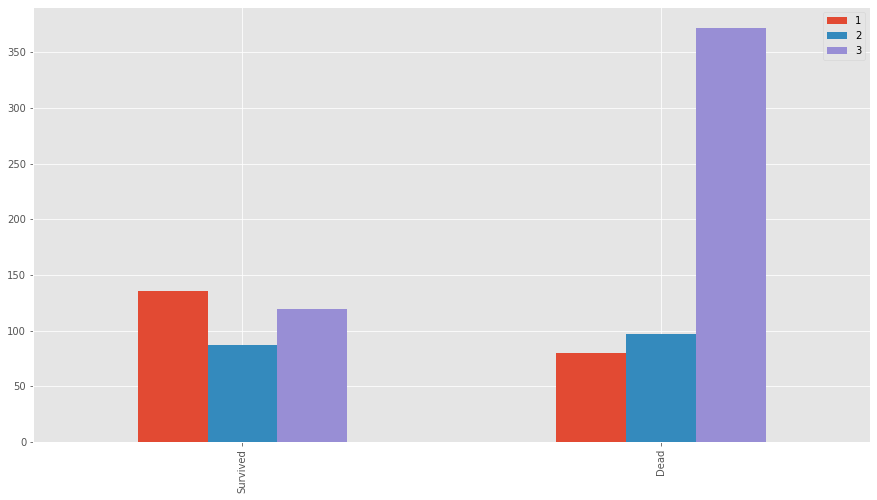

In [18]:
survived_pclass = x_train[x_train['Survived']==1]['Pclass'].value_counts()
dead_pclass = x_train[x_train['Survived']==0]['Pclass'].value_counts()
df = pd.DataFrame([survived_pclass,dead_pclass])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=False, figsize=(15,8))

x_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# the number of different class which survived

###### 我們知道船上女性的倖存率很高，男性非常低，但這現象在不同等級船票之間會有差嗎？
###### 從下方的結果，持有P1, P2等級船票的女性有高達九成的倖存率，但持有等級最低的P3船票女性只有一半的存活率。
###### 至於男性方面，持有最高等級船票P1的存活率是另外二個等級的2倍。

In [19]:
x_train[['Pclass', 'Sex', 'Survived']].groupby(['Pclass', 'Sex'], 
                                               as_index=False).mean().sort_values(by='Survived', ascending=False)

#the survived ratio of different class, sex

,Pclass,Sex,Survived
0,1,female,0.968085
2,2,female,0.921053
4,3,female,0.500000
1,1,male,0.368852
3,2,male,0.157407
5,3,male,0.135447


`4. 不同年齡層與倖存的關係` 
###### 從下圖可看出年齡愈偏向兩極（較年長或較年幼）則存活率愈高，其中尤以年齡愈小愈明顯。

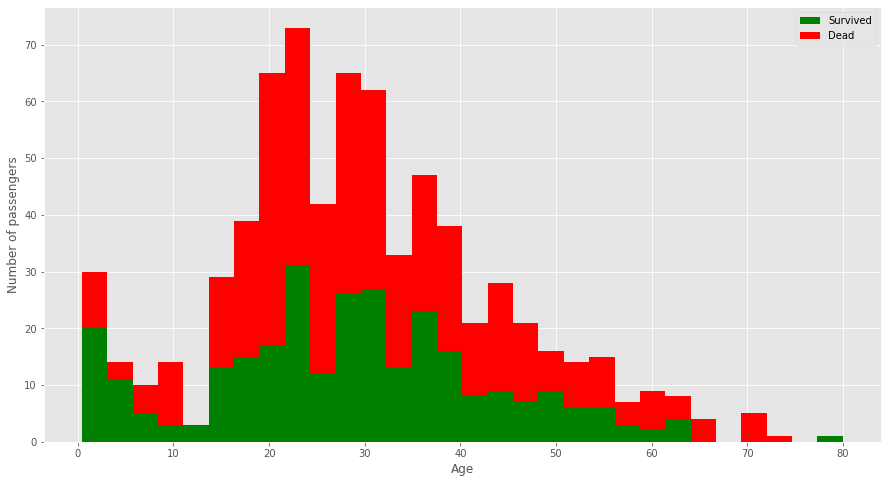

In [20]:
figure = plt.figure(figsize=(15,8))
plt.hist([x_train[x_train['Survived']==1]['Age'], 
          x_train[x_train['Survived']==0]['Age']], 
         stacked=True, 
         color = ['g','r'],
         bins = 30,
         label = ['Survived','Dead'])

plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

`5. 不同票價與存活的關係` 
###### 經由下方統計結果發現，與船票等級類似，票價愈高則存活率愈大。

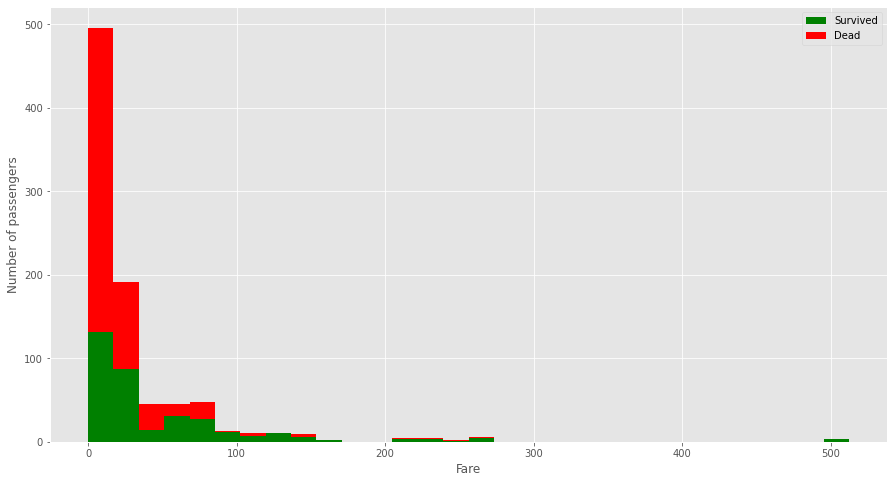

In [21]:
figure = plt.figure(figsize=(15,8))
plt.hist([x_train[x_train['Survived']==1]['Fare'],
          x_train[x_train['Survived']==0]['Fare']], 
          stacked=True, 
          color = ['g','r'],
          bins = 30,
          label = ['Survived','Dead'])

plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()


`5. 親屬人數對於存活率的影響` 
###### SibSp與Parch這兩個欄位指的是旁系與直系親屬人數，親屬或家人一起可以互相幫助，對於存活率有一定的影響。
###### 理論上直系的Parch對於倖存率影響力會比旁系SibSp更大一些。
###### 不過先不考慮兩者的差異，而是將SibSp與Parch這兩個欄位相加作為親屬人數來與存活率比較。
###### 經由下方的統計，可發現親屬人數為3人時有最高的存活率，其次為2人、１人以及6人：

In [22]:
x_train['Family'] = x_train['SibSp'] + x_train['Parch']

x_train[['Family', 'Survived']].groupby(['Family'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Family,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


`6. 上岸港口與存活率的關係` 
###### 如果從Cherbourg上船，那存活率有5成5
###### 如果從Queenstown上船那存活率降到3成8
###### 從Southampton存活率只有3成3了
###### 我們可以猜想，可能跟地區的組成人口,人口所得, 上船目的有關連

<AxesSubplot:>

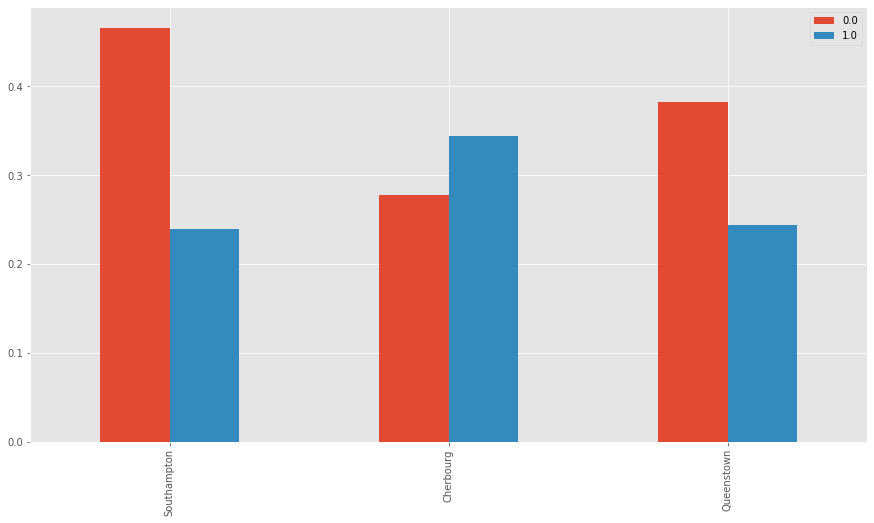

In [23]:
#complete  missing values
x_train['Embarked'] = x_train['Embarked'].fillna('S')

x_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)


total_Embarked_S = x_train[x_train['Embarked']=='S']['PassengerId'].count()
total_Embarked_C = x_train[x_train['Embarked']=='C']['PassengerId'].count()
total_Embarked_Q = x_train[x_train['Embarked']=='Q']['PassengerId'].count()

Embarked_S = x_train[x_train['Embarked']=='S']['Survived'].value_counts() / total_Embarked_S
Embarked_C = x_train[x_train['Embarked']=='C']['Survived'].value_counts() / total_Embarked_C
Embarked_Q = x_train[x_train['Embarked']=='Q']['Survived'].value_counts() / total_Embarked_Q  

             

df = pd.DataFrame([Embarked_S,Embarked_C,Embarked_Q])
df.index = ['Southampton','Cherbourg','Queenstown']
df.plot(kind='bar',stacked=False, figsize=(15,8))



###### 我們可從下方統計看出不同港口乘客有不同的經濟狀況。
###### 從法國Cherbourg上船的目的可能為出訪旅遊，大多購買等級最高的P1船票（故Cherbourg上船的有較高的存活率）
###### 來自Queenstown的乘客則有極大的比例是購買最低等級的P3船票，目的可能為工作或移民。

<AxesSubplot:>

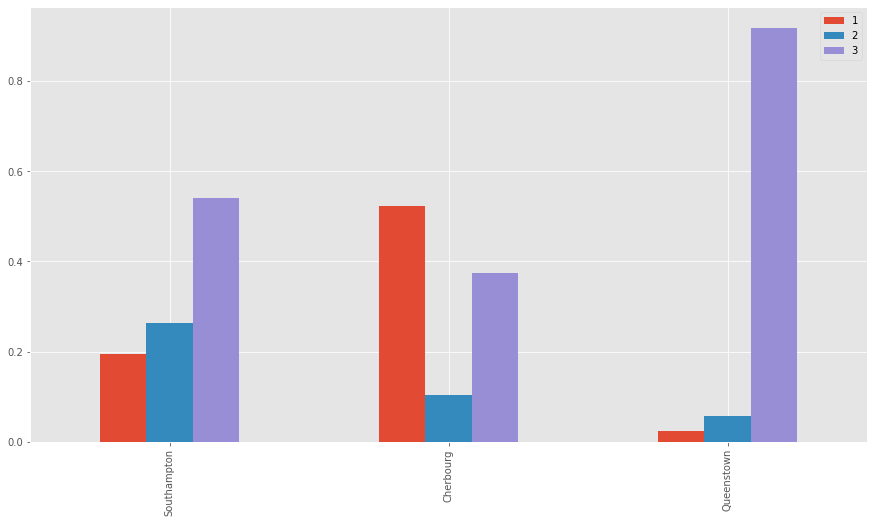

In [24]:
total_Pclass_S = x_train[x_train['Embarked']=='S']['Pclass'].count()
total_Pclass_C = x_train[x_train['Embarked']=='C']['Pclass'].count()
total_Pclass_Q = x_train[x_train['Embarked']=='Q']['Pclass'].count()

                       
Embarked_S = x_train[x_train['Embarked']=='S']['Pclass'].value_counts() / total_Pclass_S
Embarked_C = x_train[x_train['Embarked']=='C']['Pclass'].value_counts() / total_Pclass_C
Embarked_Q = x_train[x_train['Embarked']=='Q']['Pclass'].value_counts() / total_Pclass_Q  

             

df = pd.DataFrame([Embarked_S,Embarked_C,Embarked_Q])
df.index = ['Southampton','Cherbourg','Queenstown']
df.plot(kind='bar',stacked=False, figsize=(15,8))

`7. 艙房號碼與存活的關係` 
###### Cabin欄位存放的是艙房號碼，此欄位的有極大比例是空值，僅僅只有295筆記錄有值
###### 發現遺失Cabin艙房編號的，有極大比例是屬於P3最低等級船票的乘客，其次為P2，最後是P1。

In [25]:
#complete  missing values
x_train['Cabin'] = x_train['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else 'NoCabin')

In [26]:
x_train["Cabin"].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

c:\python37-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Cabin', ylabel='count'>

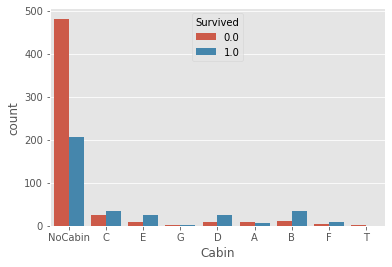

In [27]:
sns.countplot(x_train['Cabin'], hue=x_train['Survived'])

In [28]:
total_Cabin_p1 = x_train[x_train['Pclass']==1]['Cabin'].value_counts()
total_Cabin_p2 = x_train[x_train['Pclass']==2]['Cabin'].value_counts()
total_Cabin_p3 = x_train[x_train['Pclass']==3]['Cabin'].value_counts()

print('-'*5 + 'p1 class' +'-'*5)
print(total_Cabin_p1)
print('-'*5 + 'p2 class' +'-'*5)
print(total_Cabin_p2)
print('-'*5 + 'p3 class' +'-'*5)
print(total_Cabin_p3)

-----p1 class-----
C          94
NoCabin    67
B          65
D          40
E          34
A          22
T           1
Name: Cabin, dtype: int64
-----p2 class-----
NoCabin    254
F           13
D            6
E            4
Name: Cabin, dtype: int64
-----p3 class-----
NoCabin    693
F            8
G            5
E            3
Name: Cabin, dtype: int64



- [x] 特徵工程Feature engineering
   * 包含Feature cleaning、imputation、selection、encoding、normalization…等。


In [29]:
#combine SibSp&Parch to one 
x_train['Family'] = x_train['SibSp'] + x_train['Parch']
x_train.drop('SibSp' , 1, inplace=True)
x_train.drop('Parch', 1, inplace=True)

In [30]:
#check null
print('Train columns with null values:\n', x_train.isnull().sum())

#Survived have 418 , these data belong test data

Train columns with null values:
 PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
Ticket           0
Fare             1
Cabin            0
Embarked         0
Title1           0
Title2           0
Family           0
dtype: int64


In [31]:
x_train['Age'].fillna(x_train['Age'].median(), inplace = True)
#complete missing age with median
x_train['Fare'].fillna(x_train['Fare'].median(), inplace = True)
#complete missing fare with median

In [32]:
#check null again
print('Train columns with null values:\n', x_train.isnull().sum())

Train columns with null values:
 PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
Ticket           0
Fare             0
Cabin            0
Embarked         0
Title1           0
Title2           0
Family           0
dtype: int64


In [33]:
x_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked,Title1,Title2
count,1309,1309,1309,1309,1309,1309,1309
unique,1307,2,929,9,3,18,5
top,"Connolly, Miss. Kate",male,CA. 2343,NoCabin,S,Mr,Mr
freq,2,843,11,1014,916,757,757


In [34]:
x_train['Ticket_info'] = x_train['Ticket']
                         .apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')

IndentationError: unexpected indent (<ipython-input-34-648d2a19d67d>, line 2)

In [35]:
x_train['Ticket_info'].unique()

KeyError: 'Ticket_info'

In [36]:
#One-Hot Encoding

x_train['Sex'] = x_train['Sex'].map({'male':1,'female':0})    
x_train['Embarked'] = x_train['Embarked'].astype('category').cat.codes
x_train['Pclass'] = x_train['Pclass'].astype('category').cat.codes
x_train['Title1'] = x_train['Title1'].astype('category').cat.codes
x_train['Title2'] = x_train['Title2'].astype('category').cat.codes
x_train['Cabin'] = x_train['Cabin'].astype('category').cat.codes
x_train['Ticket_info'] = x_train['Ticket_info'].astype('category').cat.codes

KeyError: 'Ticket_info'

In [208]:
dataTrain = x_train[pd.notnull(x_train['Survived'])].sort_values(by=["PassengerId"])
dataTest = x_train[~pd.notnull(x_train['Survived'])].sort_values(by=["PassengerId"])

In [209]:
dataTrain.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Title1', 'Title2', 'Family',
       'Ticket_info'],
      dtype='object')

In [211]:
dataTrain = dataTrain[['Survived', 'Age', 'Embarked', 'Fare',  'Pclass', 'Sex', 'Family', 'Title2','Ticket_info','Cabin']]
dataTest = dataTest[['Age', 'Embarked', 'Fare', 'Pclass', 'Sex', 'Family', 'Title2','Ticket_info','Cabin']]

In [212]:
dataTrain

,Survived,Age,Embarked,Fare,Pclass,Sex,Family,Title2,Ticket_info,Cabin
0,0.0,22.0,2,7.2500,2,1,1,3,2,7
1,1.0,38.0,0,71.2833,0,0,1,4,14,2
2,1.0,26.0,2,7.9250,2,0,0,2,31,7
3,1.0,35.0,2,53.1000,0,0,1,4,36,2
4,0.0,35.0,2,8.0500,2,1,0,3,36,7
...,...,...,...,...,...,...,...,...,...,...
886,0.0,27.0,2,13.0000,1,1,0,1,36,7
887,1.0,19.0,2,30.0000,0,0,0,2,36,1
888,0.0,28.0,2,23.4500,2,0,3,2,34,7
889,1.0,26.0,0,30.0000,0,1,0,3,36,2


- [x] 模型建立與訓練
   * 模型選擇
   * 訓練
   * 評估
   * 參數（Hyperparameter）調整
   * 預測

In [222]:
#import package
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate

#### 特徵重要性(Feature Importance)
###### 我們使用最基本的樹狀模型 - 決策樹(Decision Tree)，來評估特徵欄位對於標籤欄位(Survived)的重要性
###### 目的是幫助我們篩選較具關鍵性的特徵欄位，提升模型的預測能力。評估特徵重要性的方法並非僅侷限於決策樹，另外其他常見的手法有：相關係數(Correlation)、Lasso等。

In [225]:
# creat decision tree model
DTC = RandomForestClassifier( )
DTC.fit( X_train, Y_train )

# impoetance rank 
col_names = X_train.columns
importances = DTC.feature_importances_
Feature_Rank = pd.DataFrame( { 'Feature_Name':col_names, 'Importance':importances } )
Feature_Rank.sort_values( by='Importance', ascending=False, inplace=True ) 
Feature_Rank

c:\python37-32\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


,Feature_Name,Importance
2,Fare,0.204454
0,Age,0.200447
4,Sex,0.198581
6,Title2,0.120134
3,Pclass,0.073034
5,Family,0.071386
8,Cabin,0.062719
7,Ticket_info,0.040051
1,Embarked,0.029194


### 在完成評估特徵重要性後，我們選擇使用隨機森林(Random Forest)來預測資料。
* n_estimators: 樹的數量(default=10)。
* min_samples_leaf: 最終葉節點最少樣本數(default=1)；當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
* min_samples_split:節點再劃分時所需的最小樣本數(default=2)；當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
* oob_score: 是否採用袋外樣本(out-of-bag samples)來評估模型的準確度(default=False)。

In [214]:
#Random Forest model (ues all Feature)
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=1000,
                             min_samples_split=12,
                             min_samples_leaf=1,
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1) 

rf.fit(dataTrain.iloc[:, 1:], dataTrain.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8294


In [226]:
X_Train = dataTrain[['Age', 'Fare',  'Pclass', 'Sex', 'Title2']]
Y_Train = dataTrain[['Survived']]
X_test = dataTest

In [230]:
#Random Forest model (just ues top 5 Feature)
RFC_2 = RandomForestClassifier(criterion='gini', 
                             n_estimators=1000,
                             min_samples_split=12,
                             min_samples_leaf=1,
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1) 

RFC_2.fit( X_Train, Y_Train )
print("%.4f" % RFC_2.oob_score_)

c:\python37-32\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


0.8462
